# Pacotes e dados

## Pacotes

In [0]:
# Install Kaggle API for download competition data
!pip3 install -q kaggle

In [57]:
!pip install pydicom

In [0]:
# Importar os pacotes
import numpy as np
import pandas as pd
import os
import random 
from shutil import copyfile
import pydicom as dicom
import cv2
import matplotlib.pyplot as plt
from matplotlib.image import imread

from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras import backend as K 
K.set_image_data_format('channels_last')

## Dados

### Kaggle rsna

In [0]:
kjson = pd.read_json('kaggle.json',typ='series')

In [0]:
# enter your Kaggle credentionals here

os.environ['KAGGLE_USERNAME']= "matheuscoradini"
os.environ['KAGGLE_KEY']= kjson.key

In [61]:
!kaggle datasets download --force tawsifurrahman/covid19-radiography-database

100% 1.14G/1.15G [00:18<00:00, 66.1MB/s]
100% 1.15G/1.15G [00:18<00:00, 68.0MB/s]


In [62]:
!unzip covid19-radiography-database.zip

Archive:  covid19-radiography-database.zip
replace COVID-19 Radiography Database/COVID-19.metadata.xlsx? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace COVID-19 Radiography Database/COVID-19.metadata.xlsx? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: COVID-19 Radiography Database/COVID-19.metadata.xlsx  
  inflating: COVID-19 Radiography Database/COVID-19/COVID-19 (1).png  
  inflating: COVID-19 Radiography Database/COVID-19/COVID-19 (10).png  
  inflating: COVID-19 Radiography Database/COVID-19/COVID-19 (100).png  
  inflating: COVID-19 Radiography Database/COVID-19/COVID-19 (101).png  
  inflating: COVID-19 Radiography Database/COVID-19/COVID-19 (102).png  
  inflating: COVID-19 Radiography Database/COVID-19/COVID-19 (103).png  
  inflating: COVID-19 Radiography Database/COVID-19/COVID-19 (104).png  
  inflating: COVID-19 Radiography Database/COVID-19/COVID-19 (105).png  
  inflating: COVID-19 Radiography Database/COVID-19/COVID-19 (106).png  
  

## Diretório de imagem

In [63]:
# Lista o conteúdo 
os.listdir('COVID-19 Radiography Database/')

['README.md.txt',
 'NORMAL',
 'Viral Pneumonia',
 'COVID-19',
 'COVID-19.metadata.xlsx',
 'Viral Pneumonia.matadata.xlsx',
 'NORMAL.metadata.xlsx']

In [0]:
imagens_normal = 'COVID-19 Radiography Database/NORMAL'
imagens_covid = 'COVID-19 Radiography Database/COVID-19'
imagens_pneu = 'COVID-19 Radiography Database/Viral Pneumonia'

In [65]:
print(len(os.listdir(imagens_normal)))

1341


In [66]:
print(len(os.listdir(imagens_covid)))

219


In [67]:
print(len(os.listdir(imagens_pneu)))

1345


In [0]:
covid_image_list = os.listdir(imagens_normal)
normal_image_list = os.listdir(imagens_covid)
pneu_image_list = os.listdir(imagens_pneu)

# Preparing features

In [0]:
paths = []
y = []

for dirname, _, filenames in os.walk('COVID-19 Radiography Database/Viral Pneumonia'):
    for filename in filenames:
        if (filename[-3:] == 'png'):
            paths.append(os.path.join(dirname, filename))
            y.append(0)
for dirname, _, filenames in os.walk('COVID-19 Radiography Database/NORMAL'):
    for filename in filenames:
        if (filename[-3:] == 'png'):
            paths.append(os.path.join(dirname, filename))
            y.append(1)   
for dirname, _, filenames in os.walk('COVID-19 Radiography Database/COVID-19'):
    for filename in filenames:
        if (filename[-3:] == 'png'):
            paths.append(os.path.join(dirname, filename))
            y.append(2)

In [70]:
len(paths)

2905

In [71]:
len(y)

2905

In [0]:
X = []
for i in paths:
    image = cv2.imread(i)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, (128, 128))

    X.append(image)

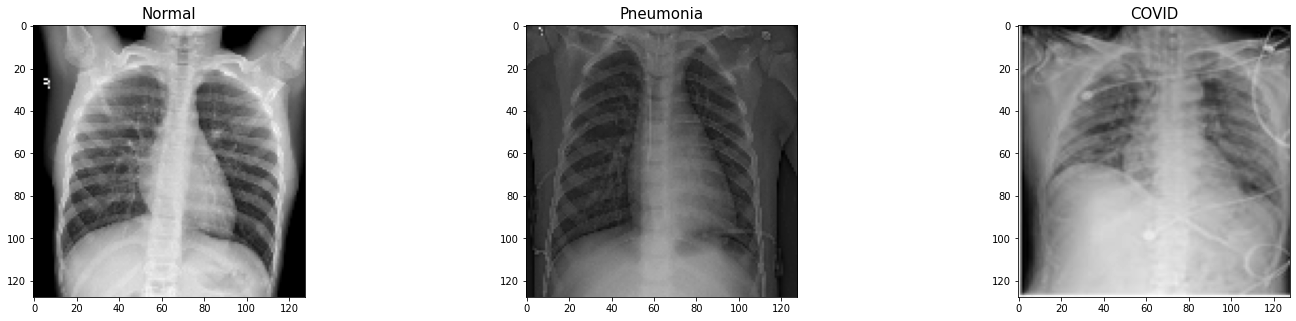

In [73]:
fig, (ax1, ax2,ax3) = plt.subplots(ncols = 3,nrows = 1, figsize = (25,5))
ax1.imshow(X[1500],cmap='gray')
ax2.imshow(X[0],cmap='gray')
ax3.imshow(X[2900],cmap='gray')

ax1.set_title('Normal',fontsize=15)
ax2.set_title('Pneumonia',fontsize=15)
ax3.set_title('COVID',fontsize=15)

plt.show()

In [0]:
X = np.array(X)/255
y = np.array(y)

In [0]:
X = X.reshape(-1,128,128,1)

In [76]:
X.shape

(2905, 128, 128, 1)

# Train Test Split

In [0]:
Xtrain, Xval, ytrain, yval  = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [0]:
ycat_val = to_categorical(yval,3)
ycat_train = to_categorical(ytrain,3)

# Model

In [0]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=(128,128,1), activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=(61,61,1), activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(30))

model.add(Dense(3))
model.add(Activation('softmax'))

model.compile(optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [111]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 30, 30, 64)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 57600)            

In [0]:
early_stop = EarlyStopping(monitor='val_loss',patience=15)

In [0]:
image_gen = ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               zoom_range=0.05, # Zoom in by 5% max
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )

In [115]:
cw = {0: 1, 1: 1, 2:2}
BS = 32
results = model.fit_generator(image_gen.flow(Xtrain, ycat_train, batch_size=BS),
                              steps_per_epoch=len(Xtrain)/BS, epochs=100,
                              validation_data=(Xval,ycat_val), callbacks = [early_stop], class_weight = cw)

Epoch 1/100
69/68 [==============================] - 3s 50ms/step - loss: 1.2911 - accuracy: 0.5197 - val_loss: 0.5023 - val_accuracy: 0.8102
Epoch 2/100
69/68 [==============================] - 3s 49ms/step - loss: 0.5589 - accuracy: 0.7994 - val_loss: 0.3566 - val_accuracy: 0.8624
Epoch 3/100
69/68 [==============================] - 3s 48ms/step - loss: 0.4435 - accuracy: 0.8411 - val_loss: 0.3266 - val_accuracy: 0.8762
Epoch 4/100
69/68 [==============================] - 3s 48ms/step - loss: 0.3965 - accuracy: 0.8678 - val_loss: 0.2516 - val_accuracy: 0.8982
Epoch 5/100
69/68 [==============================] - 3s 48ms/step - loss: 0.3446 - accuracy: 0.8825 - val_loss: 0.2790 - val_accuracy: 0.9010
Epoch 6/100
69/68 [==============================] - 3s 48ms/step - loss: 0.2943 - accuracy: 0.9031 - val_loss: 0.2275 - val_accuracy: 0.9161
Epoch 7/100
69/68 [==============================] - 3s 49ms/step - loss: 0.2955 - accuracy: 0.8958 - val_loss: 0.2249 - val_accuracy: 0.9243
Epoch 

In [116]:
model.metrics_names

['loss', 'accuracy']

In [0]:
losses = pd.DataFrame(model.history.history)

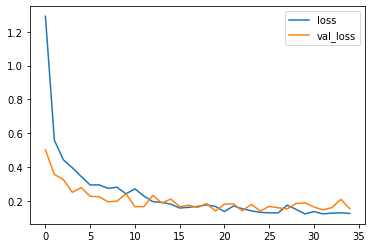

In [118]:
losses[['loss','val_loss']].plot()
plt.show()

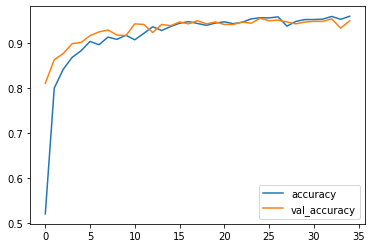

In [119]:
losses[['accuracy','val_accuracy']].plot()
plt.show()

In [0]:
pred = model.predict_classes(Xval)

In [121]:
# 1: Pneumonia
# 2: Normal
# 3: COVID-19

from sklearn.metrics import classification_report
print(classification_report(yval, pred))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95       341
           1       0.94      0.96      0.95       337
           2       0.96      0.94      0.95        49

    accuracy                           0.95       727
   macro avg       0.95      0.95      0.95       727
weighted avg       0.95      0.95      0.95       727



In [122]:
from sklearn.metrics import confusion_matrix
confusion_matrix(yval, pred)

array([[319,  20,   2],
       [ 12, 325,   0],
       [  3,   0,  46]])